# Import Library

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
from desdeo_mcdm.interactive.NautilusNavigator import NautilusNavigator

In [8]:
from graph import Graph, Point
from optimization import generate_rand_points, crossover, dominates, non_dominated_sort, crowding_distance, random_connected_partitions

# Generate Graph

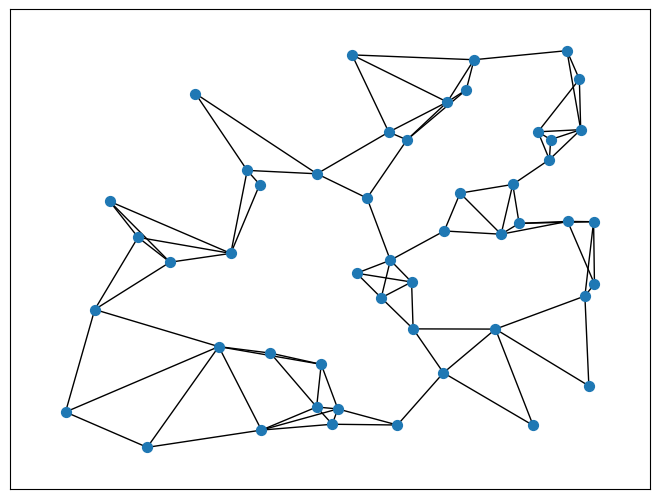

In [36]:
np.random.seed(15)

n_points = 50
n_partition = 4
interval = [-30, 30]

graph = generate_rand_points(Graph(), n_points, interval)
points_x, points_y = graph.get_points_coords()

weight = graph.calculate_weight(3, 4)
pos = {i: (graph.get_points()[i].get("x"), graph.get_points()[i].get("y")) for i in graph.get_points()}

G = nx.Graph(np.array(weight))
nx.draw(G, node_size=50, pos=pos)
plt.axis("on")
plt.show()

# To Excel

In [39]:
weight_df = pd.DataFrame(weight)
weight_df.to_csv('weight.csv')

# NSGA 2

## Objective Function

In [40]:
def f1_obj(edge_cut):
    sum = 0
    for i in edge_cut: 
        sum += edge_cut.get(i, 0)
    return sum

def f2_obj(graph, n):
    sum = 0
    for i in range(n - 1):
        for j in range(i, n):
            sum += np.abs(graph.get_partition_size(i + 1) - graph.get_partition_size(j + 1)) 
    return sum

def f3_obj(graph, n):
    sum = 0
    for i in range(n):
        sum += graph.get_partition_spread(i + 1)
    return sum

In [43]:
mutation_rate = 0.8
crossover_rate = 0.3
n_iteration = 500
n_population = 1000

In [44]:
populations = np.array([])
for i in tqdm(range(n_population)):
    new_graph = deepcopy(graph) 
    random_connected_partitions(new_graph, weight, n_partition)
    populations = np.append(new_graph, populations)

for i in tqdm(range(n_iteration)):
    populations_with_offspring = np.copy(populations)

    for i in range(n_population // 2):
        a = deepcopy(populations[np.random.randint(0, n_population)])
        b = deepcopy(populations[np.random.randint(0, n_population)])
        
        populations = np.append(new_graph, populations)
        if(np.random.rand() <= crossover_rate):
            a, b = crossover(a, b, n_partition)
        if(np.random.rand() <= mutation_rate):
            a.mutate_graph()
        if(np.random.rand() <= mutation_rate):
            b.mutate_graph()
        
        populations_with_offspring = np.append(populations_with_offspring, [a, b])

    f_list = np.array([])
    for i, population in enumerate(populations_with_offspring):
        f_list = np.append(f_list, [i, f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

    f_list = f_list.reshape(n_population * 2, 4)

    fronts = non_dominated_sort(f_list)
    fronts = fronts[:len(fronts) - 1]
    crowding_distance_list = []

    for i, front in enumerate(fronts):
        crowding_distance_list.append([])
        crowding_distance_list[i] = crowding_distance(front, f_list[:, 1:])

    new_population = np.array([])

    for i, front in enumerate(fronts):
        front_temp = sorted([[front[j], crowding_distance_list[i][j]] for j in range(len(crowding_distance_list[i]))], key=lambda x: x[1], reverse=True)
        for val in front_temp:
            if(len(new_population) < n_population):
                new_population = np.append(new_population, populations_with_offspring[val[0]])
            else: 
                break
        else:
            continue
        break

    populations = np.copy(new_population)

100%|██████████| 500/500 [3:16:47<00:00, 23.62s/it]  


In [ ]:
f_list = np.array([])

for i, population in enumerate(populations):
    f_list = np.append(f_list, [f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)])

f_list = f_list.reshape(n_population, 3)

px.scatter_3d(x=f_list[:, 0], y=f_list[:, 1], z=f_list[:, 2], opacity=0.5)

## Generate CSV

In [45]:
columns = np.append(np.array(['f1', 'f2', 'f3']), ['var' for i in range(n_points)])
output = pd.DataFrame(columns=columns)

for population in populations: 
    f1, f2, f3 = f1_obj(population.get_edge_cut()), f2_obj(population, n_partition), f3_obj(population, n_partition)
    var = population.get_partition()
    data = np.append([f1, f2, f3], [val for val in var])
    output.loc[len(output)] = data

output.to_excel('output.xlsx')

## Load CSV

In [46]:
output = pd.read_excel('output.xlsx')
f1, f2, f3 = output.f1, output.f2, output.f3

In [47]:
px.scatter_3d(output, x='f1', y='f2', z='f3', opacity=0.5)

# Interactive

In [173]:
front = np.array([f1, f2, f3], dtype=object).T
nadir = np.array([np.max(f1), np.max(f2), np.max(f3)])
ideal = np.array([np.min(f1), np.min(f2), np.min(f3)])
method = NautilusNavigator(front, ideal, nadir)

print(f"Nadir Point: {nadir}")
print(f"Ideal Point: {ideal}")

Nadir Point: [ 57.0825977  138.          68.18262375]
Ideal Point: [25.61619234  6.         29.18885634]


In [174]:
req_first = method.start()
print(req_first.content["reachable_lb"])
print(req_first.content["reachable_ub"])

[25.61619234  6.         29.18885634]
[ 57.0825977  138.          68.18262375]


In [175]:
reference_point = np.array([40, 20, 50])
go_to_previous = False
stop = False
speed = 1

response = dict(reference_point=reference_point, go_to_previous=False, stop=False, speed=1, user_bounds=[None, None, None])

In [176]:
req_first.response = response
req_snd = method.iterate(req_first)

print(req_snd.content["reachable_lb"])
print(req_snd.content["reachable_ub"])

[25.61619234  6.         29.43957138]
[ 57.0825977  138.          68.18262375]


In [177]:
previous_requests = [req_first, req_snd]
req = req_snd
while method._step_number < 30:
    req.response = response
    req = method.iterate(req)

    previous_requests.append(req)

print(req.content["reachable_lb"])
print(req.content["reachable_ub"])
print(req.content["step_number"])

[25.61619234  6.         45.78221893]
[ 51.80309693 108.          68.18262375]
30


In [178]:
# fetch the 14th step saved previously
req_14 = previous_requests[13]
print(req_14.content["reachable_lb"])
print(req_14.content["reachable_ub"])
print(req_14.content["step_number"])

req_14.response["go_to_previous"] = True
req_14.response["reference_point"] = np.array([30, 20, 50])
new_response = req_14.response

[25.61619234  6.         45.78221893]
[ 51.80309693 108.          68.18262375]
14


In [179]:
req_14_new = method.iterate(req_14)
req = req_14_new

# remember to unser go_to_previous!
new_response["go_to_previous"] = False

# continue iterating for 16 steps
while method._step_number < 30:
    req.response = new_response
    req = method.iterate(req)

print("Old 30th step")
print(previous_requests[29].content["reachable_lb"])
print(previous_requests[29].content["reachable_ub"])
print(previous_requests[29].content["step_number"])

print("New 30th step")
print(req.content["reachable_lb"])
print(req.content["reachable_ub"])
print(req.content["step_number"])

Old 30th step
[25.61619234  6.         45.78221893]
[ 51.80309693 108.          68.18262375]
30
New 30th step
[25.61619234  6.         45.78221893]
[ 51.80309693 108.          68.18262375]
30


In [180]:
while method._step_number < 100:
    req.response = new_response
    req = method.iterate(req)

print(req.content["reachable_idx"])

[214 222 938]


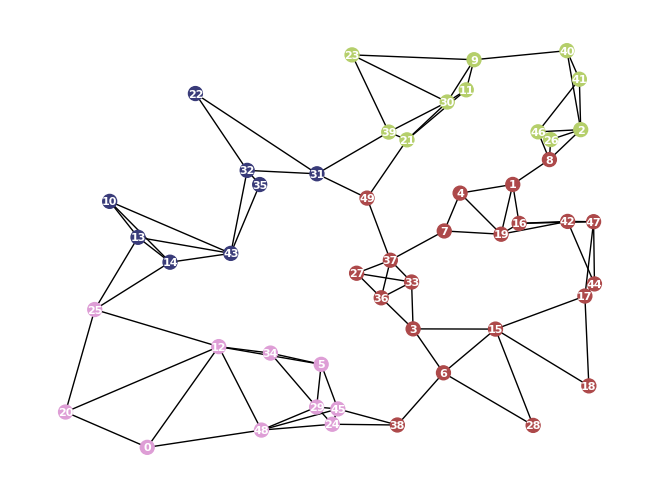

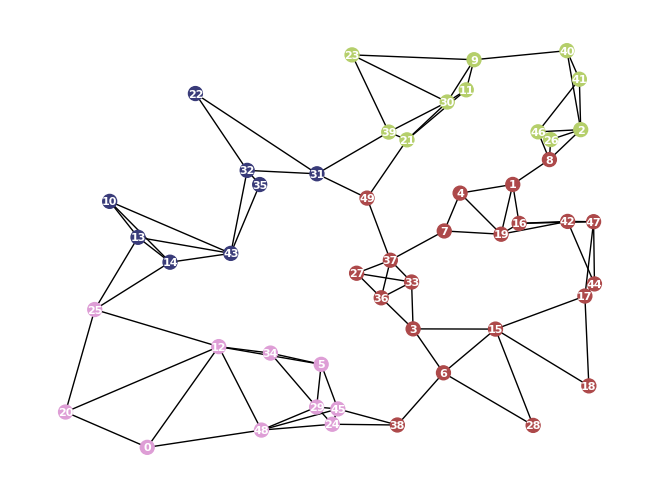

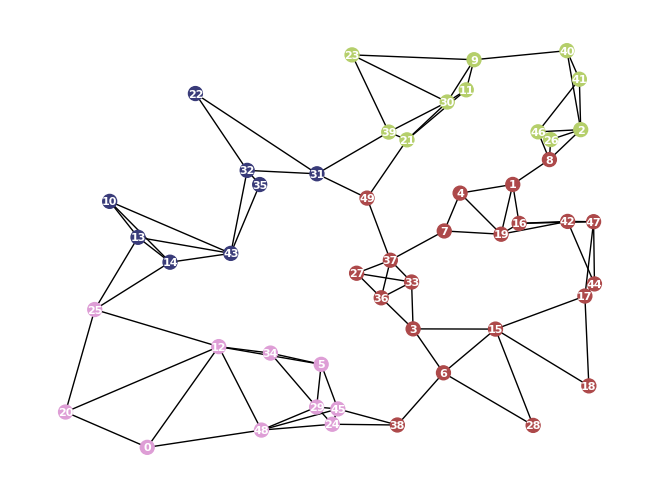

In [181]:
for i in req.content["reachable_idx"]:
    partition_result = populations[i].get_partition()
    node_colors = [partition_result[node] for node in G.nodes()]
    labels = {node: f'{node}' for node in G.nodes()}
    label_pos = {k: (v[0], v[1]) for k, v in pos.items()}  

    plt.figure()
    nx.draw(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.tab20b)
    nx.draw_networkx_labels(G, pos=label_pos, labels=labels, font_size=8, font_color='white', font_weight='800')

    plt.show()